# Incremental impacts of chemistry updates on HCHO

In [1]:
%matplotlib inline

In [2]:
import copy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature

from cartopy_cmaqfile import cmaqfile

In [3]:
workdir = './'
data_dir = f'{workdir}/data'

## ocean mask file

In [4]:
ocnf = f'{data_dir}/oceanmask/12US1_surf.ncf'
ocn = xr.open_dataset(ocnf)
# 1 over land; NaN elsewhere; set threshold of 0.5 (i.e., mask if ocean > 0.5 grid cell area)
ocn_mask = xr.where(ocn['OPEN']>0.5, np.full(ocn['OPEN'].shape, np.nan), np.ones(ocn['OPEN'].shape)).squeeze().values
ocn.close()

## cmaq data

In [5]:
cases = [
    'CRACMM1', # base CRACMM1
    'AMORE',   # add AMORE isoprene chemistry
    'ECH4',    # add emitted CH4 species ECH4
    'HET',     # heterogeneous uptake of HO2 and NO3
    'MT',      # monoterpene updates
    'ARO',     # aromatics updates
]
indir = f'{data_dir}/cmaq/seasonal_averages_summer'
# summer average (11am-3pm local time)
aconc_11to3 = {case: xr.open_dataset(f'./{indir}/combine_aconc_hcho_summer_mean_2019_11am_to_3pm_LST_{case}.nc') for case in cases}

## CMAQ grid projection info

In [6]:
gridcro_fn = f'{data_dir}/gridcro/GRIDCRO2D_20190101.nc4'
gridcro = xr.open_dataset(gridcro_fn)
gridcro = cmaqfile(gridcro)
Xcorners, Ycorners = gridcro.getXYcorners()
cmaqproj = gridcro.getCMAQproj()

## plot helper functions and settings

In [7]:
def txt_annot(Z, fmt='.1f'):
    txt = f'{Z.mean():{fmt}} ({Z.min():{fmt}}, {Z.max():{fmt}})'
    plt.annotate(txt, xy=(0, -.08), xycoords='axes fraction')

In [8]:
def axis_fix(ax):
    ax.coastlines(lw=.25)
    ax.add_feature(cfeature.STATES, lw=.25)
    ax.add_feature(cfeature.BORDERS, lw=.25)
    ax.set_facecolor('grey')

In [9]:
plt.rcParams.update({'font.size': 10})

## summer average 11am-3pm (Figure S10)

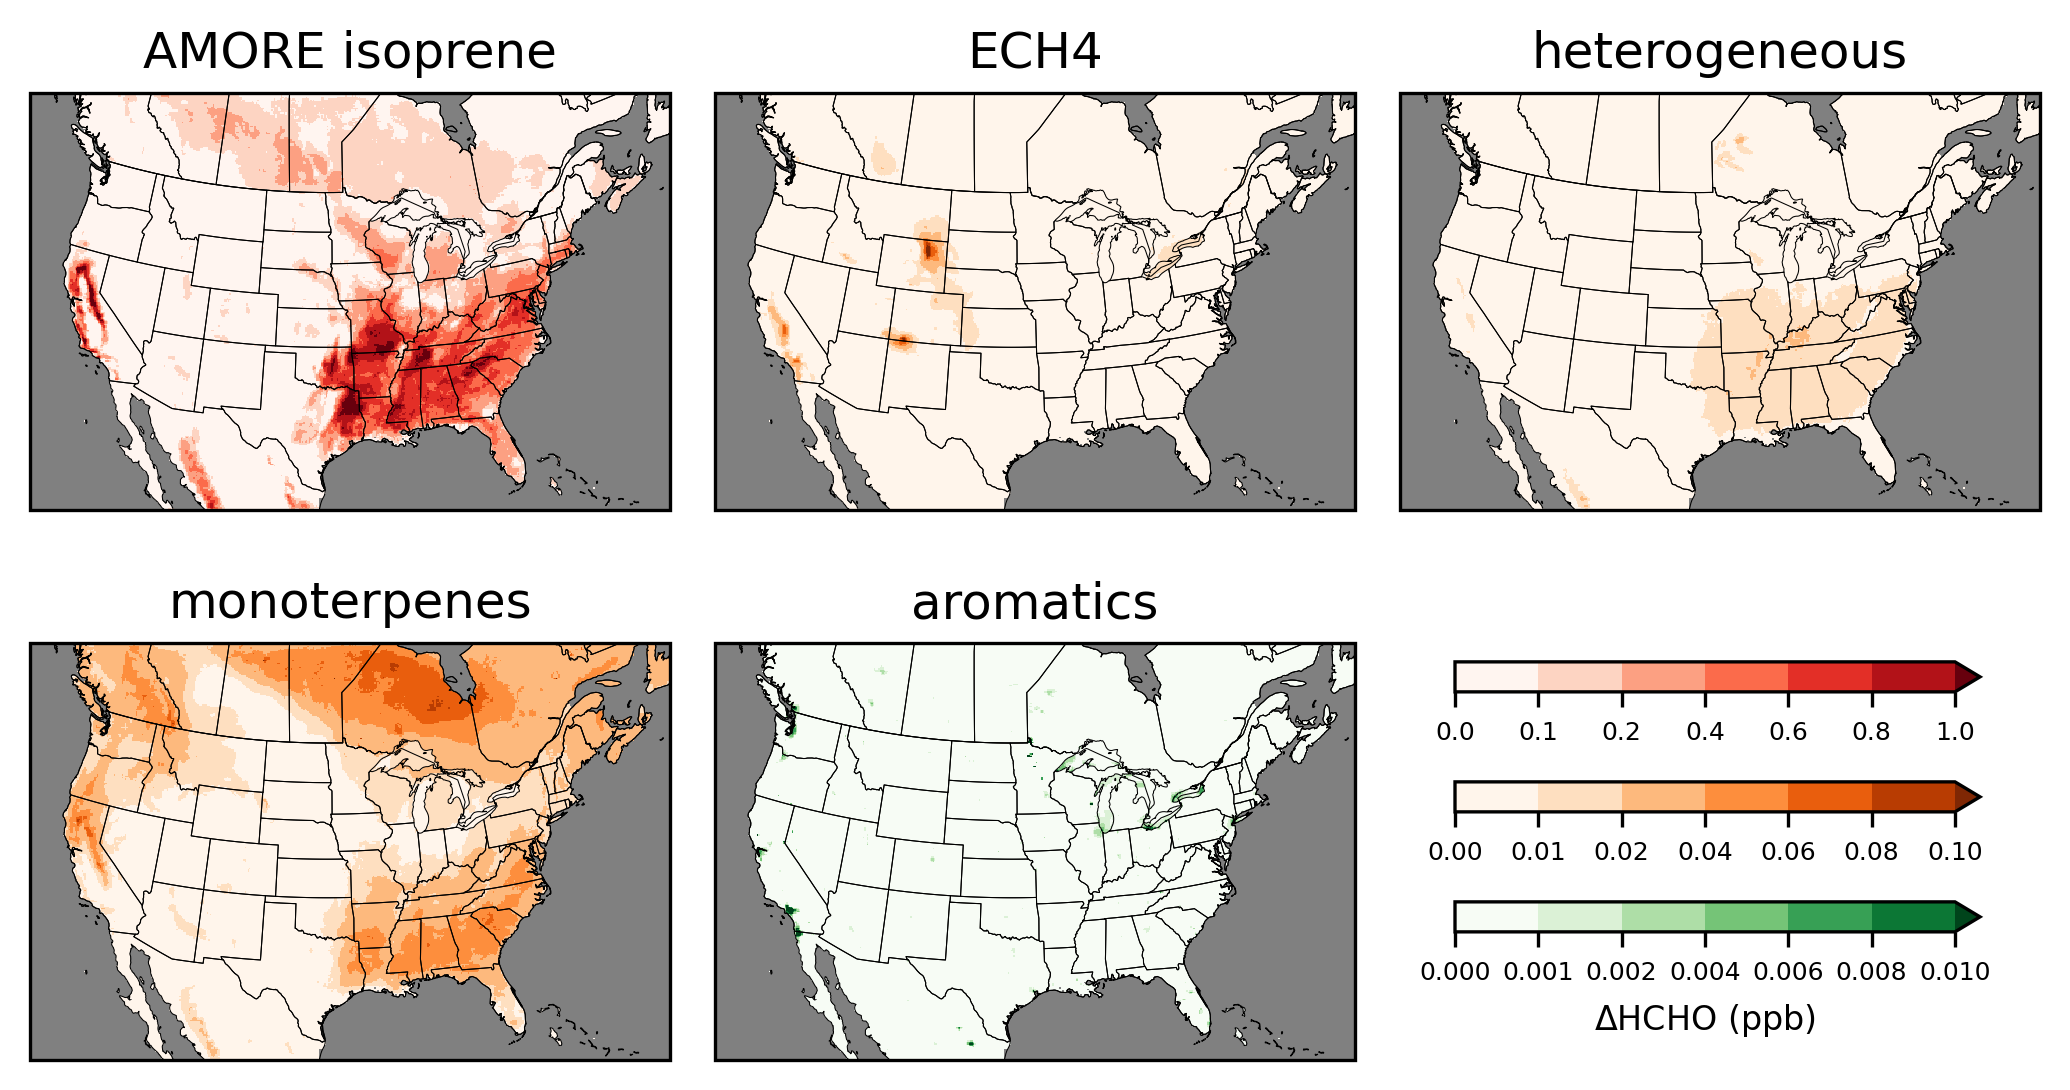

In [10]:
# discrete colorbar
bounds = np.arange(0., 4.01, .5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')
bounds_delta = [0., .1, .2, .4, .6, .8, 1.]
scale_bounds = {
    'AMORE': 1.,
    'ECH4':   .1,
    'HET':    .1,
    'MT':     .1,
    'ARO':    .01
}

cmaps = {
    'AMORE': 'Reds',
    'ECH4':  'Oranges',
    'HET':   'Oranges',
    'MT':    'Oranges',
    'ARO':   'Greens'
}

case_titles = {
    'AMORE': 'AMORE isoprene',
    'ECH4':  'ECH4',
    'HET':   'heterogeneous',
    'MT':    'monoterpenes',
    'ARO':   'aromatics'
}

fig = plt.figure(figsize=(7, 4), dpi=300)
mappable = {}
Zdeltas = {}
for i, case in enumerate(cases):
    
    ds = aconc_11to3[case]
    
    if case == 'CRACMM1': # just need to get the values to compare to AMORE case
        Zprev = copy.deepcopy(ds['HCHO'].load()*ocn_mask)
        continue
    
    # plot change in this case - previous case
    scale = scale_bounds[case]
    bounds_delta_thiscase = [x*scale for x in bounds_delta]
    norm_delta = mcolors.BoundaryNorm(boundaries=bounds_delta_thiscase, ncolors=256, extend='max')
    cmap = cmaps[case]
    Z = ds['HCHO'].load()*ocn_mask
    ax = fig.add_subplot(2,3,i, projection=cmaqproj)
    Zdeltas[case] = Z - Zprev
    mappable[case] = ax.pcolormesh(
        Xcorners,
        Ycorners,
        Zdeltas[case],
        cmap=cmap,
        norm=norm_delta
    )
    ax.set_title(case_titles[case])
    # txt_annot(Zdeltas[case], fmt='.1e')
    axis_fix(ax)
    # update previous case
    Zprev = copy.deepcopy(Z)

plt.tight_layout()
# colorbar AMORE isoprene
cax = fig.add_axes([.7, .4, 0.25, .025])
cbar_props = dict(orientation='horizontal')
cbar = plt.colorbar(mappable['AMORE'], cax=cax, **cbar_props)
cbar.ax.tick_params(labelsize=6)
# colorbar ECH4, heterogeneous, monoterpenes
cax = fig.add_axes([.7, .3, 0.25, .025])
cbar_props = dict(orientation='horizontal')
cbar = plt.colorbar(mappable['MT'], cax=cax, **cbar_props)
cbar.ax.tick_params(labelsize=6)
# colorbar aromatics
cax = fig.add_axes([.7, .2, 0.25, .025])
cbar_props = dict(orientation='horizontal')
cbar = plt.colorbar(mappable['ARO'], cax=cax, **cbar_props)
cbar.set_label('$\Delta$HCHO (ppb)', size=8)
cbar.ax.tick_params(labelsize=6)

## just show AMORE and MT (Figure 3)

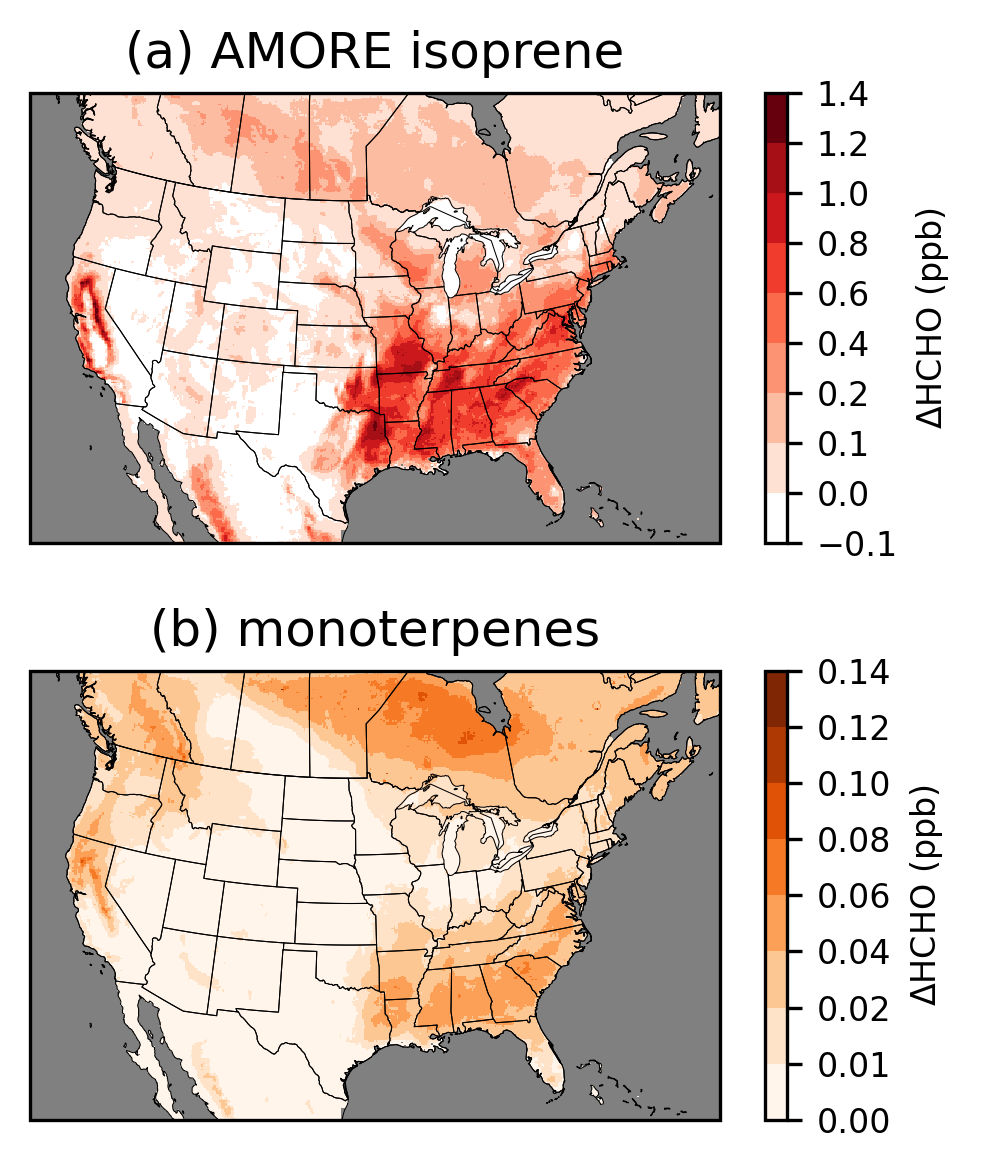

In [11]:
# discrete colorbar
bounds = np.arange(0., 4.01, .5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

plot_cases = ['AMORE', 'MT']

bounds_delta = {
    'AMORE': [-.1, 0., .1, .2, .4, .6, .8, 1., 1.2, 1.4],
    'MT':    [0., .01, .02, .04, .06, .08, .1, .12, .14]
}
case_titles = {
    'AMORE': 'AMORE isoprene',
    'MT':    'monoterpenes'
}

case_letters = {
    'AMORE': '(a)',
    'MT':    '(b)'
}

cmaps = {
    'AMORE': copy.copy(plt.cm.Reds),
    'MT':    copy.copy(plt.cm.Oranges),
}

fig = plt.figure(figsize=(3.5, 4), dpi=300)
mappable = {}
for i, case in enumerate(plot_cases):
    
    # plot change in this case - previous case
    bounds_delta_thiscase = bounds_delta[case]
    norm_delta = mcolors.BoundaryNorm(boundaries=bounds_delta_thiscase, ncolors=256, extend='neither')
    cmap = cmaps[case]
    if case == 'AMORE':
        # update colormap to make negative values show up as white
        cmaplist = [cmap(j) for j in range(cmap.N)]
        cmaplist[0] = (1.0, 1.0, 1.0, 1.0) # RGBA for white
        cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    ax = fig.add_subplot(2,1,i+1, projection=cmaqproj)
    Zdelta = Zdeltas[case]
    mappable[case] = ax.pcolormesh(
        Xcorners,
        Ycorners,
        Zdelta,
        cmap=cmap,
        norm=norm_delta
    )
    ax.set_title(f'{case_letters[case]} {case_titles[case]}')
    cbar = plt.colorbar(mappable[case], orientation='vertical')
    cbar.set_label('$\Delta$HCHO (ppb)', size=8)
    cbar.ax.tick_params(labelsize=8)
    # txt_annot(Zdeltas[case], fmt='.3f')
    axis_fix(ax)

plt.tight_layout()
fig.savefig('figures/fig03.tiff')